# Model Training
  * All the codes and preprocessed data are uploaded to Google Drive
  * Colab mount the Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## Train code location

In [2]:
%cd /content/gdrive/My Drive/cs598_DL4H/CNN_design_for_AD

/content/gdrive/My Drive/cs598_DL4H/CNN_design_for_AD


## Train model


```
usage: python3 main.py [-h] [--config CONFIG] [--expansion EXPANSION] [--percentage_usage PERCENTAGE_USAGE]

options:
  -h, --help            show this help message and exit
  --config CONFIG       config
  --expansion EXPANSION
                        expansions to decide the width of the model
  --percentage_usage PERCENTAGE_USAGE
                        percentage of data to use for training
```



In [35]:
!python3 main.py --config config_200 --expansion 8

has module!
In total  135  patients in training set
Epoch: [0][0/35]	Time 2.553 (2.553)	Data 0.633 (0.633)	Loss 1.0959 (1.0959)	Accuracy 75.000	
Epoch: [0][10/35]	Time 0.959 (1.084)	Data 0.000 (0.060)	Loss 1.3339 (1.2497)	Accuracy 25.000	
Epoch: [0][20/35]	Time 0.954 (1.019)	Data 0.017 (0.032)	Loss 1.0673 (1.1884)	Accuracy 50.000	
Epoch: [0][30/35]	Time 0.922 (0.992)	Data 0.000 (0.022)	Loss 1.1739 (1.1724)	Accuracy 25.000	
/content/gdrive/MyDrive/cs598_DL4H/CNN_design_for_AD/main.py:259: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logit_all.append(torch.tensor(logit.data.cpu()))
/content/gdrive/MyDrive/cs598_DL4H/CNN_design_for_AD/main.py:260: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor)

In [4]:
import tensorflow as tf
print(f"GPU Available: {tf.test.is_gpu_available()}")
print(f"GPU Name: {tf.test.gpu_device_name()}")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU Available: True
GPU Name: /device:GPU:0


# Model Evaluation
  * Note: Modify config_name and model_file_name accordingly.

In [5]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.nn.functional as F
import os
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
# from scipy import interp
import matplotlib.pyplot as plt
from numpy.random import permutation
import yaml

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [36]:
config_name = 'config_200.yaml'
with open(os.path.join('./'+config_name), 'r') as f:
    cfg = yaml.safe_load(f)

In [8]:
from datasets.adni_3d import ADNI_3D
from models.build_model import build_model

## Config the location of preprocessed data and corresponding TSV files

In [31]:
dir_to_scans = '/content/gdrive/My Drive/cs598_DL4H/ADNI_processed_200/subjects'
dir_to_tsv = '/content/gdrive/My Drive/cs598_DL4H/ADNI_converted_meta_all/sample_200'
Test_dataset = ADNI_3D(dir_to_scans, dir_to_tsv, mode = 'Test',  n_label = cfg['model']['n_label'])
Test_loader = torch.utils.data.DataLoader(
        Test_dataset, batch_size=cfg['data']['val_batch_size'], shuffle=False,
        num_workers=cfg['data']['workers'], pin_memory=True)

In [10]:
category = ['CN','MCI','AD']

In [11]:
def visualize_example(Test_dataset,sub_id):
    plt.figure(figsize=(10, 10))
    image = Test_dataset.__getitem__(sub_id)[0][0]
    plt.subplot(1, 3, 1)
    plt.imshow(np.rot90(image[26,:,:]),cmap = 'gray')
    plt.ylabel('Subject '+str(sub_id) + ' in Test dataset', fontsize=10)
    plt.title('Class: '+category[Test_dataset.__getitem__(sub_id)[1]] , fontsize=10)
    plt.subplot(1, 3, 2)
    plt.imshow(np.rot90(image[:,57,:]),cmap = 'gray')
    plt.title('Class: '+category[Test_dataset.__getitem__(sub_id)[1]], fontsize=10)
    plt.subplot(1, 3, 3)
    plt.imshow(np.rot90(image[:,:,50]),cmap = 'gray')
    plt.title('Class: '+category[Test_dataset.__getitem__(sub_id)[1]], fontsize=10)

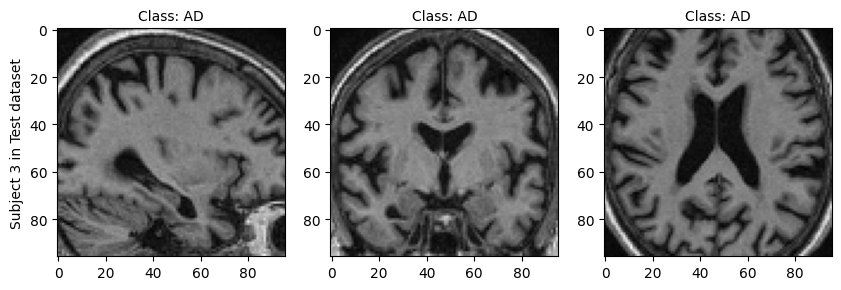

In [12]:
visualize_example(Test_dataset,3)

In [13]:
from sklearn.metrics import confusion_matrix
def balanced_accuracy_score(y_true, y_pred, sample_weight=None,
                            adjusted=False):
    C = confusion_matrix(y_true, y_pred, sample_weight=sample_weight)
    with np.errstate(divide='ignore', invalid='ignore'):
        per_class = np.diag(C) / C.sum(axis=1)
    if np.any(np.isnan(per_class)):
        warnings.warn('y_pred contains classes not in y_true')
        per_class = per_class[~np.isnan(per_class)]
    score = np.mean(per_class)
    if adjusted:
        n_classes = len(per_class)
        chance = 1 / n_classes
        score -= chance
        score /= 1 - chance
    return score

In [14]:
def calc_aucs(target_all,logit_all):
    y = label_binarize(target_all, classes=[0,1,2])
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for k in range(cfg['model']['n_label']):
        fpr[k], tpr[k], _ = roc_curve(y[:, k], logit_all[:, k])
        roc_auc[k] = auc(fpr[k], tpr[k])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), logit_all.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    all_fpr = np.unique(np.concatenate([fpr[k] for k in range(cfg['model']['n_label'])]))

    mean_tpr = np.zeros_like(all_fpr)
    for k in range(cfg['model']['n_label']):
        mean_tpr += np.interp(all_fpr, fpr[k], tpr[k])

    # Finally average it and compute AUC
    mean_tpr /= cfg['model']['n_label']

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    return roc_auc

In [15]:
def plot_rocs(target_all,logit_all):
    y = label_binarize(target_all, classes=[0,1,2])
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for k in range(cfg['model']['n_label']):
        fpr[k], tpr[k], _ = roc_curve(y[:, k], logit_all[:, k])
        roc_auc[k] = auc(fpr[k], tpr[k])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), logit_all.ravel())
    roc_auc[k+1] = auc(fpr["micro"], tpr["micro"])
    all_fpr = np.unique(np.concatenate([fpr[k] for k in range(cfg['model']['n_label'])]))

    mean_tpr = np.zeros_like(all_fpr)
    for k in range(cfg['model']['n_label']):
        mean_tpr += np.interp(all_fpr, fpr[k], tpr[k])

    # Finally average it and compute AUC
    mean_tpr /= cfg['model']['n_label']

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc[k+2] = auc(fpr["macro"], tpr["macro"])
    plotting_fpr = []
    plotting_tpr = []
    for k in range(cfg['model']['n_label']):
        plotting_fpr.append(fpr[k])
        plotting_tpr.append(tpr[k])
    plotting_fpr += [fpr["micro"], fpr["macro"]]
    plotting_tpr += [tpr["micro"], tpr["macro"]]
    auc_outs = [plotting_fpr, plotting_tpr, roc_auc]
    name = ['CN vs all ','MCI vs all ', 'AD vs all ', 'Micro ', 'Macro ']
    from itertools import cycle
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue','navy','deeppink'])
    plt.figure()
    for i, color in zip(range(len(auc_outs[0])), colors):
        plt.plot(auc_outs[0][i], auc_outs[1][i], color=color, lw=2, label=name[i] + 'ROC curve (area = %0.2f)' % auc_outs[2][i])
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC curves')
    plt.legend(loc="lower right")

In [16]:
def run_epoch(model,val_loader,use_age=False):
    logit_all = []
    target_all = []
    mmse_all = []
    patient_idx_all = []
    cdr_all = []
    for i, (input, target, patient_idx, mmse, cdr_sub, age_id) in enumerate(val_loader):
        if i % 20 == 0:
            print('Iteration: ',i)
        input = input.to(device)
        target = target.to(device)
        if use_age:
            age_id = age_id.to(device)
        else:
            age_id = None
        logit = model(input,age_id)
        logit_all.append(logit.data.cpu())
        target_all.append(target.data.cpu())
        mmse_all.append(mmse.cpu())
        patient_idx_all.append(patient_idx.cpu())
        cdr_all.append(cdr_sub.cpu())

    logit_all_catted = torch.cat(logit_all)
    target_all_catted = torch.cat(target_all)
    mmse_all_catted = torch.cat(mmse_all)
    patient_idx_all_catted = torch.cat(patient_idx_all)
    cdr_all_catted = torch.cat(cdr_all)
    return logit_all_catted.numpy(), target_all_catted.numpy(), mmse_all_catted.numpy(), patient_idx_all_catted.numpy(), cdr_all_catted.numpy()

In [17]:
def evaluation_models(model_name,data_loader, expansion_list = [1],  num_trails = 10,percentage = 0.8, use_age = False, norm_type= 'Instance'):

    all_acc = np.zeros((len(expansion_list),num_trails))
    all_balanced_acc = np.zeros((len(expansion_list),num_trails))
    all_auc = []
    for i,ep in enumerate(expansion_list):
        cfg['model']['expansion'] = ep
        cfg['model']['norm_type'] = norm_type
        model = build_model(cfg)
        best_model_dir = './saved_model/'
        pretrained_dict = torch.load(best_model_dir+model_name + '_model_low_loss.pth.tar',map_location='cpu', weights_only=False)['state_dict']
        old_ks = list(pretrained_dict.keys()).copy()
        model_dict = model.state_dict()
        pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items() if (k[6:]in model_dict.keys())}
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)
        model = model.to(device)
        model = model.eval()
        logit_all,target_all,_,_,_= run_epoch(model, data_loader, use_age)
        #print(F.softmax(torch.tensor(logit_all[0:20]),dim=1))
        tes_auc = []
        for tes in range(num_trails):
            rand_idex = permutation(range(len(target_all)))[:int(percentage*len(target_all))]
            target_test = target_all[rand_idex]
            pred_test = np.argmax(logit_all,1)[rand_idex]
            logit_test = logit_all[rand_idex]
            all_acc[i,tes] =accuracy_score(target_test, pred_test)
            all_balanced_acc[i,tes] =balanced_accuracy_score(target_test, pred_test)
            tes_auc.append(calc_aucs(target_test,logit_test))
        plot_rocs(target_test,logit_test)
        all_auc.append(tes_auc)
        print(old_ks)
        print(list(pretrained_dict.keys()))
    return all_acc, all_balanced_acc, all_auc

In [18]:
def test_model(all_acc, all_balanced_acc,all_auc):
    for w_k in range(len(all_acc)):
        print('Mean Acc ', np.mean(all_acc[w_k]),'\t')
        print('STD Acc ', np.std(all_acc[w_k]),'\t')
        print('Mean Balanced Acc ', np.mean(all_balanced_acc[w_k]),'\t')
        print('std Balanced Acc ', np.std(all_balanced_acc[w_k]),'\t')
        avg_micro = []
        avg_macro = []
        for d in all_auc[w_k]:
            avg_micro.append( d['micro'])
            avg_macro.append( d['macro'])
        print('Micro mean: ',np.mean(avg_micro))
        print('Micro std: ', np.std(avg_micro))
        print('Macro mean: ',np.mean(avg_macro))
        print('Macro std: ',np.std(avg_macro))

## Load the trained model
   * The trained models are saved under /content/gdrive/My Drive/cs598_DL4H/CNN_design_for_AD/saved_model

In [40]:
model = build_model(cfg)
# model_file_name = 'age_expansion_8' # Author's model
# model_file_name = "200_pooling_age_train_perc_100.0_expansion_0"
model_file_name = "200_pooling_age_train_perc_100.0_expansion_8"
# model_file_name = "alexNet_pooling_train_perc_100.0_expansion_0"
# model_file_name = "200_bn_no_age_train_perc_100.0_expansion_8"
# model_file_name = "200_use_age_train_perc_100.0_expansion_8"

Iteration:  0
['model.image_embedding_model.conv.conv0_s1.weight', 'model.image_embedding_model.conv.conv0_s1.bias', 'model.image_embedding_model.conv.conv1_s1.weight', 'model.image_embedding_model.conv.conv1_s1.bias', 'model.image_embedding_model.conv.conv2_s1.weight', 'model.image_embedding_model.conv.conv2_s1.bias', 'model.image_embedding_model.conv.conv3_s1.weight', 'model.image_embedding_model.conv.conv3_s1.bias', 'model.image_embedding_model.fc6.fc6_s1.weight', 'model.image_embedding_model.fc6.fc6_s1.bias', 'model.image_embedding_model.age_encoder.pe', 'model.image_embedding_model.age_encoder.fc6.fc6_s1.weight', 'model.image_embedding_model.age_encoder.fc6.fc6_s1.bias', 'model.image_embedding_model.age_encoder.fc6.lrn0_s1.weight', 'model.image_embedding_model.age_encoder.fc6.lrn0_s1.bias', 'model.image_embedding_model.age_encoder.fc6.fc6_s3.weight', 'model.image_embedding_model.age_encoder.fc6.fc6_s3.bias', 'model.classifier.classifier.LinearClassifier.weight', 'model.classifier.

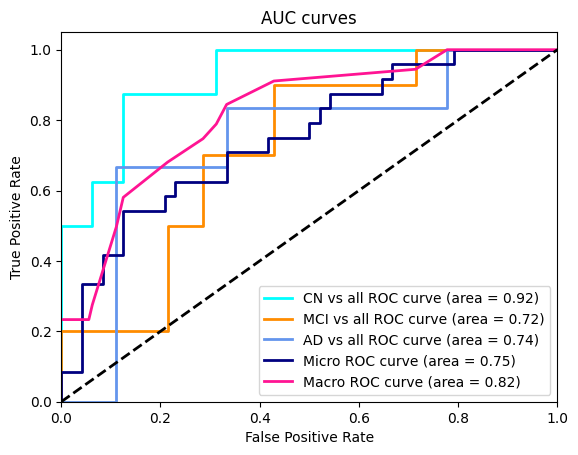

In [41]:
all_acc, all_balanced_acc, all_auc = evaluation_models(model_file_name,Test_loader, expansion_list = [8], use_age = False, norm_type= 'Instance')

In [42]:
test_model(all_acc, all_balanced_acc,all_auc)

Mean Acc  0.5583333333333333 	
STD Acc  0.062360956446232366 	
Mean Balanced Acc  0.5663203463203463 	
std Balanced Acc  0.028446351671532713 	
Micro mean:  0.7571180555555554
Micro std:  0.030069825344007824
Macro mean:  0.7997878155411281
Macro std:  0.019106193289687393
